**DSCI 100 Final Project**

This report analyzes data from the Minecraft Server created by a UBC research group led by Frank Wood. In doing so, this project sets out to find **which variables in the *players.csv* data set are the best predictors of newsletter subscription**. This will be an important first step towards answering the broad question of interest:

**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**


The *players.csv* dataset consists of the following variables:

**experience:**
This variable measures each player's experience classification.

**subscription:**
This variable measures each player's subscription status.

**hashedEmail:**
This variable appears to be an encrypted version of each player's email address.

**played_hours:**
This variable measures the total hours played by each player.

**name:**
This variable contains each player's name.

**gender:**
This variable contains information on each player's gender identification.

**Age:**
This variable contains information on each player's age.

**General Methodology:**
In this report, we will conduct and optimize K-NN classification algorithm for every variable that we consider to be a relevant predictor of subscription status, that is, we are excluding the *hashedEmail* and *name* columns from our analysis. Then we will compare various methods of testing these models that we have learned throughout the course such as Accuracy, Precision, and Recall. Note that for the gender variable, we will use a clustering model over a K-NN classification to determine the sufficiency of the variable as a predictor, as the lack of a numeric scale makes computing similarity using K-NN difficult.



In [1]:
print("Loading data")

library(tidyverse)
library(repr)
library(tidymodels)
library(tidyclust)
library(forcats)
options(repr.matrix.max.rows = 6)
players <- read_csv("Data/players.csv")

[1] "Loading data"


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Methods & Results:
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 

note: all figures should have a figure number and a legend

**Indira:** I will determining if gender is a good predictor of subscription status. 

**Step 1:** Since gender does not run on a numerical scale, the distance between categories is not meaningful in the same way it would be for actual numeric variables. I will instead generate a clustering model to examine if different genders have different subscription patterns. 

# A tibble: 7 × 2
  num_clusters total_WSSD
         <int>      <dbl>
1            1     1365  
2            2     1031. 
3            3      871. 
4            4      597. 
5            5      439. 
6            6      195. 
7            7       75.2


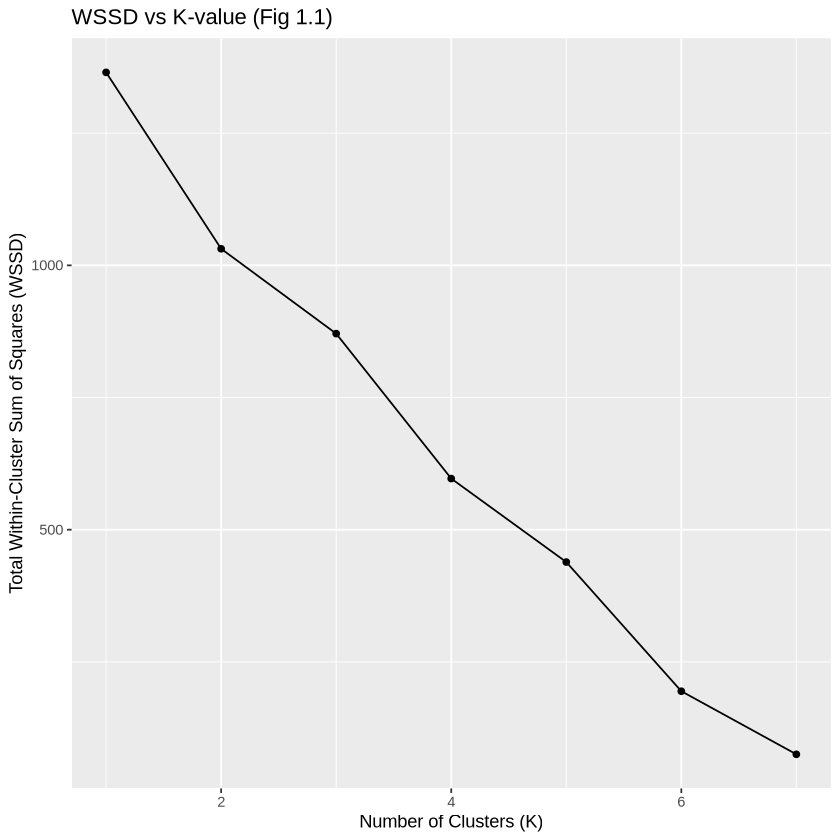

In [2]:
players_gender <- players |> select(subscribe, gender) 
gender_cleaned <- players_gender |> mutate(subscribe = as.numeric(subscribe), gender = (as.factor(gender)))

gender_ks <- tibble(num_clusters = 1:7)
kmeans_recipe <- recipe(~ ., data = gender_cleaned) |> step_dummy(all_nominal_predictors()) |>
step_normalize(all_predictors())
kmeans_spec_tune <- k_means(num_clusters = tune()) |> set_engine("stats", nstart = 10)
gender_fit <- workflow() |> add_recipe(kmeans_recipe) |> add_model(kmeans_spec_tune)
kmeans_tuning_stats <- gender_fit |> tune_cluster(resamples = apparent(gender_cleaned), grid = gender_ks) |> 
collect_metrics() 
kmeans_stats_tidy <- kmeans_tuning_stats |> mutate(total_WSSD = mean) |> filter(.metric == "sse_within_total") |>
select(num_clusters, total_WSSD)
print(kmeans_stats_tidy)

elbow_plot <- kmeans_stats_tidy |> ggplot(aes(x = num_clusters, y = total_WSSD)) + geom_point() + geom_line() + 
xlab("Number of Clusters (K)") + ylab("Total Within-Cluster Sum of Squares (WSSD)") + ggtitle("WSSD vs K-value (Fig 1.1)")
elbow_plot

In this first step, I selected the two relevant variables, *gender* and *subscribe*. In order to run the classification model, I then changed subscription status and gender to factor variables. I ran into issues using the typical *step_scale* and *step_center* functions, since it treats these factors like continuous variables instead of categorical ones. After some research, I found using "one-hot" encoding (*step_dummy*) essentially generates its own axis or dimension for each category, keeping them separate and preventing fake distances from being created. (James et. al, 2013) The *step_normalize* function then standardizes all the predictor variables, which resolved the issues

To evaluate the best number of clusters, I preformed clustering for a range of K's (1-7, as there are seven possible categories in the data set) and filtered for the within-cluster sum of squares distance. Using the 'elbow' plot, we can see there isn't really a clear ideal number of clusters. There is a very slight elbow at K = 3, so we will use this in our model.

**Step 2:**

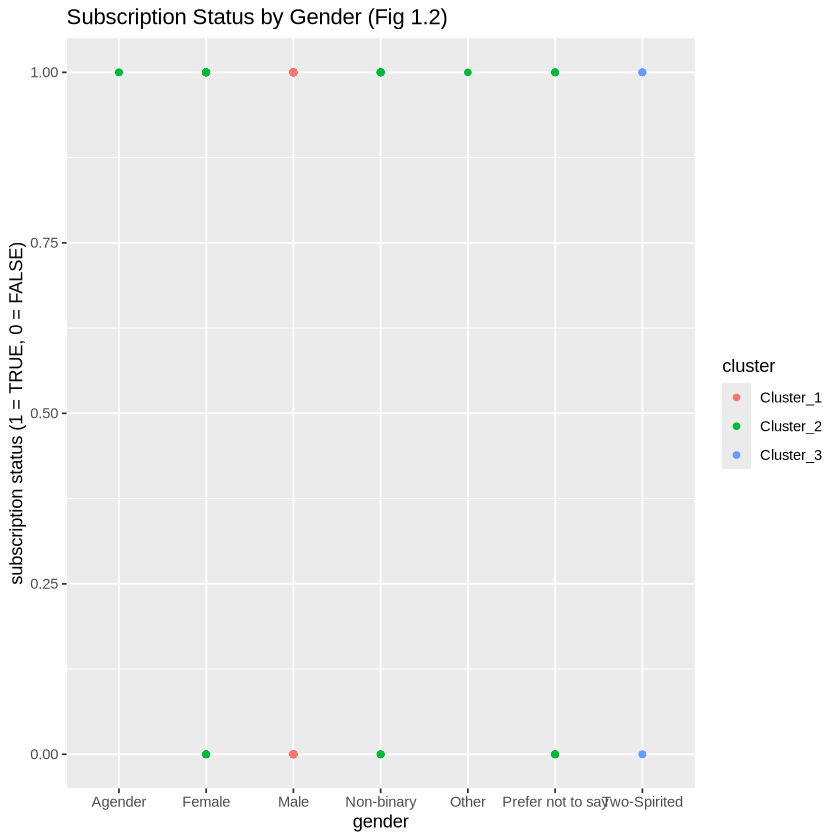

In [3]:
kmeans_spec <- k_means(num_clusters = 3) |> set_engine("stats", nstart = 10)
kmeans_fit <- workflow() |> add_recipe(kmeans_recipe) |> add_model(kmeans_spec) |> fit(data = gender_cleaned)
gender_labelled <- augment(kmeans_fit, gender_cleaned)

cluster_plot_3 <- gender_labelled |> ggplot(aes(x = gender, y = subscribe)) + geom_point(aes(color = .pred_cluster)) + 
labs(x = "gender", y = "subscription status (1 = TRUE, 0 = FALSE)", color = "cluster") + ggtitle("Subscription Status by Gender (Fig 1.2)")
cluster_plot_3


From the clustering, we see that the *Female* and *Other* categories, or cluster 2, share similar subscription patterns, while *Male*, *Agender*, *Non-binary*, and *Two-Spirited*, or cluster 1, also share patterns. *Prefer not to say* is it's own category as well, cluster 3. Because of the binary nature of the subscription column, this visualization isn't really enough to go on, so I will generate a bar plot to further visualize the subscription patterns.

**Step 3:**

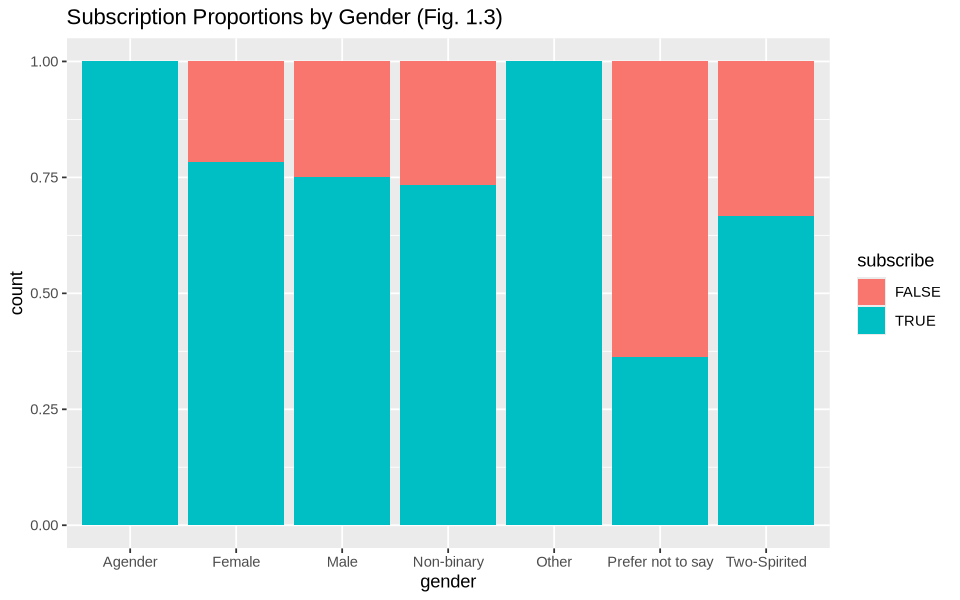

In [4]:
options(repr.plot.width = 8, repr.plot.height = 5)
players_gender_vis <- players_gender |> ggplot(aes(gender, fill = subscribe)) + geom_bar(stat = "count", position = "fill") + 
ggtitle("Subscription Proportions by Gender (Fig. 1.3)")
players_gender_vis

Combining the bar plot and the clustering, we can see cluster 3 seems to indicate a higher chance of *not* subscribing, with around 64% not subscribing. Cluster 2 and 1 appear similar, and its difficult to interpret what patterns they may be presenting, especially since *Other* and *Agender* depict the same data, but are in different clusters. If anything, cluster 2 includes genders where the subscription rate is over 75%, with the exception being *Agender*, who has a subscription rate of 100% but falls into category 2. This could possibly have been caused by an unlucky clustering center, or it could be a genuine error we have no way of visuallizing. 

We can make rough estimates about someone's subscription status based on their gender, (for example, a female gamer is, according to the data, about 75% likely to subscribe), but the ambiguity in the *prefer not to say* column skews results for future predicitons. I feel that on its own, gender isn't a very strong predictor of someone's subscription status.

**Max:** I will be looking at how good of a predictor Age is for Subscription status.

In [5]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**Step 1:**

In [6]:
player_age <- players |>
    select(Age, subscribe) |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != "NA")

player_age

Age,subscribe
<dbl>,<fct>
9,TRUE
17,TRUE
17,FALSE
⋮,⋮
22,FALSE
57,FALSE
17,FALSE


In this step I selected my two variables of interest, *Age* and *subscribe*. I then converted the subscribe variable into a factor so that it would work within a K-NN classfication algorithhm. Finally, I filtered out the NA values from the age column, now this data is tidied, wrangled and ready to be put into a classification model. 

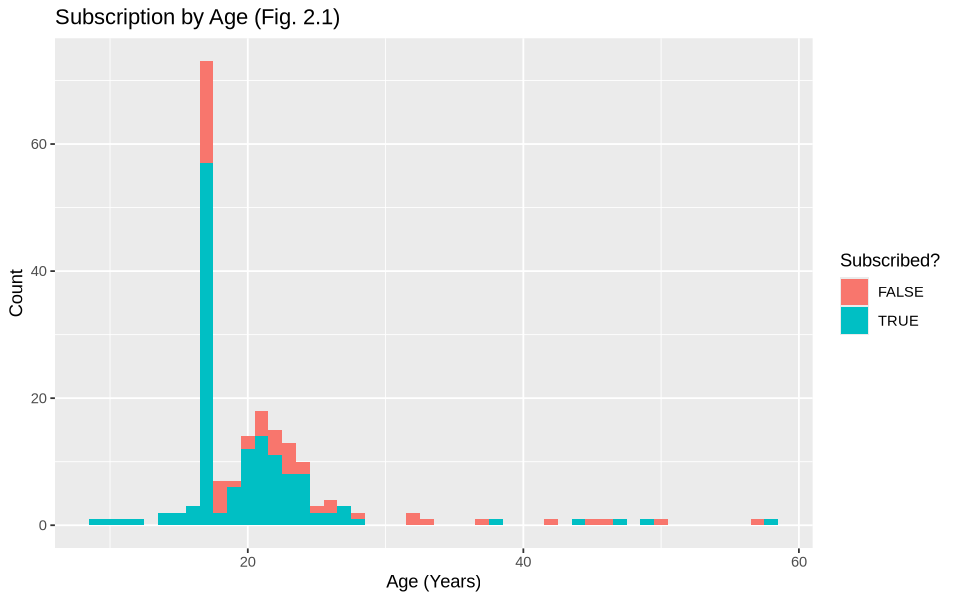

In [28]:
player_age_hist <- player_age |>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram(binwidth = 1) +
    labs(x = "Age (Years)", y = "Count", fill = "Subscribed?", title = "Subscription by Age (Fig. 2.1)")

player_age_hist

**Step 2**

Splitting the dataset into training data and testing data. This seperation allows me to test the accuracy of the model.

In [23]:
# dividing data into training and testing sets
set.seed(9999)
player_age_split <- initial_split(player_age, prop = 0.75, strata = subscribe)
player_age_train <- training(player_age_split)
player_age_test <- testing(player_age_split)

**Step 3**

Determining the optimal number of neighbors for the most accurate knn model using cross fold validation. 

In [24]:
set.seed(9999) #keep results consistent

#recipe
player_age_recipe <- recipe(subscribe ~ Age, data = player_age_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#knn model
player_age_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_mode("classification") |>
    set_engine("kknn")

#player age workflow

vfolds <- vfold_cv(player_age_train, v = 10, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

player_age_workflow_tune <- workflow() |>
    add_model(player_age_model_tune) |>
    add_recipe(player_age_recipe) |>
    tune_grid(resamples = vfolds, grid = k_vals)


player_age_results <-  player_age_workflow_tune |>
    collect_metrics()

player_age_results |>
    filter(.metric == "accuracy") |>
    slice_max(order_by = mean, n = 1, with_ties = FALSE)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,accuracy,binary,0.7450183,10,0.01363246,Preprocessor1_Model29


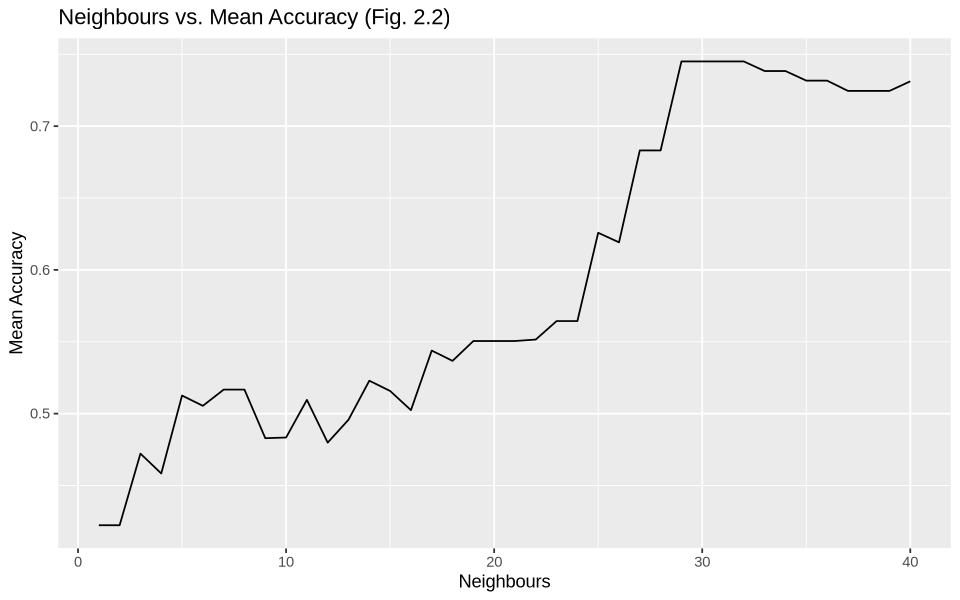

In [30]:
player_age_plot <- player_age_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    labs(x = "Neighbours", y = "Mean Accuracy", title = "Neighbours vs. Mean Accuracy (Fig. 2.2)")

player_age_plot

**Step 4**

Using the most accurate number of neighbours to train a knn classification model on the training data, and then testing its accuracy on the testing data to determine how well age is at predicting whether or not a player is subscribed to a gaming-related newsletter.

In [26]:
player_age_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 29) |>
    set_mode("classification") |>
    set_engine("kknn")

player_age_workflow <- workflow() |>
    add_model(player_age_model) |>
    add_recipe(player_age_recipe) |>
    fit(data = player_age_train)

player_age_prediction <- predict(player_age_workflow, player_age_test) |>
                          bind_cols(player_age_test)

subscribed_prediction_accuracy <- player_age_prediction |>
                        metrics(truth = subscribe, estimate = .pred_class)

subscribed_prediction_accuracy |>
    filter(.metric == "accuracy") |>
    select(.metric, .estimate)

.metric,.estimate
<chr>,<dbl>
accuracy,0.7142857


**Martin:** I will be looking at whether played hours are a good predictors of player subscription status.

In [12]:
players <- read_csv("Data/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Summary Statistics for *played_hours*:**

In [13]:
 hours_played_summary <- players %>%
  summarise(
    mean_played_hours = mean(played_hours, na.rm = TRUE),
    median_played_hours = median(played_hours, na.rm = TRUE),
    min_played_hours = min(played_hours, na.rm = TRUE),
    max_played_hours = max(played_hours, na.rm = TRUE),
    sd_played_hours = sd(played_hours, na.rm = TRUE))
hours_played_summary

mean_played_hours,median_played_hours,min_played_hours,max_played_hours,sd_played_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.845918,0.1,0,223.1,28.35734


**Visually Representing Played Hours Distribution:**

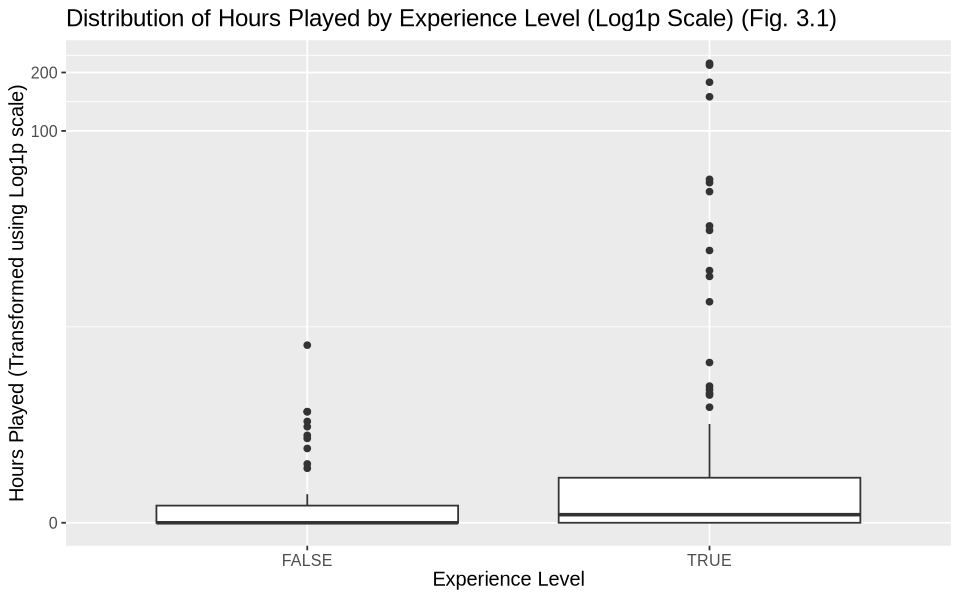

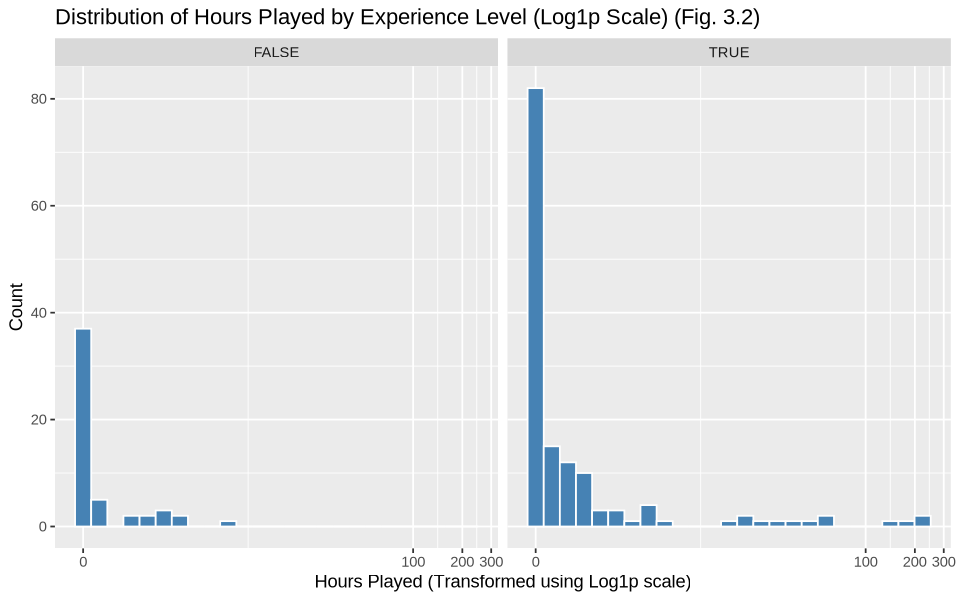

In [32]:
distribution_plot <- players %>%
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  scale_y_continuous(trans = "log1p")+ 
  labs(title = "Distribution of Hours Played by Experience Level (Log1p Scale) (Fig. 3.1)",
       x = "Experience Level",
       y = "Hours Played (Transformed using Log1p scale)") +
  theme(text = element_text(size = 12)) 
distribution_plot

histogram_plot <- players %>%
  ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 25, fill = "steelblue", color = "white")+
    facet_grid(cols = vars(subscribe))+
    scale_x_continuous(trans = "log1p")+
    labs(title = "Distribution of Hours Played by Experience Level (Log1p Scale) (Fig. 3.2)",
         x = "Hours Played (Transformed using Log1p scale)",
         y = "Count")
histogram_plot
    

While making this plot, I ran into a significant issue because of the number of zero values in the hours_played variable; the distribution was extremely skewed. Because of this, making effective visualizations required the use of the log1p scale to allow the bottom tail of the values and the more extreme outliers to be visible; using a scaling factor of log10 was not applicable because log10(0) is an undefined value.

To answer my question, **Can player hours played be reliable predictors of newsletter subscription status?** I will run a K-NN prediction model with hours played as a predictor of newslletter subscription status. 

**KNN Model:**

**Step 1:** Clean Data

In [15]:
players_cln <- players %>%
    mutate(subscribe = as_factor(subscribe))%>%
    select(subscribe, played_hours) %>%
    drop_na()
players_cln

subscribe,played_hours
<fct>,<dbl>
TRUE,30.3
TRUE,3.8
FALSE,0.0
⋮,⋮
FALSE,0.0
FALSE,2.3
TRUE,0.2


*In the code above, I have converted the original **subscribe** data into a factor data type, and I have also removed all other variables that are not necessary for my analysis*

**Step 2:** Tune Model 

In [16]:
set.seed(123)

players_split <- initial_split(players_cln, prop = 0.75)
player_train <- training(players_split)
player_test <- testing(players_split)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_mode("classification") %>%
                set_engine("kknn")
knn_recipe <- recipe(subscribe ~ played_hours, data = player_train) %>%
  step_center(all_predictors()) %>%
  step_scale(all_predictors()) 

knn_wf <- workflow() %>%
        add_model(knn_spec) %>%
        add_recipe(knn_recipe)

player_vfolds <- vfold_cv(player_train, v = 5)

knn_results <- tune_grid(
  knn_wf,
  resamples = player_vfolds,
  grid = 20,
  metrics = metric_set(accuracy)
)
knn_results <- collect_metrics(knn_results)
knn_results 



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6457471,5,0.03100126,Preprocessor1_Model01
3,accuracy,binary,0.6862069,5,0.03819829,Preprocessor1_Model02
4,accuracy,binary,0.6793103,5,0.03709279,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.6931034,5,0.03229456,Preprocessor1_Model11
13,accuracy,binary,0.7137931,5,0.01910952,Preprocessor1_Model12
14,accuracy,binary,0.7137931,5,0.01910952,Preprocessor1_Model13


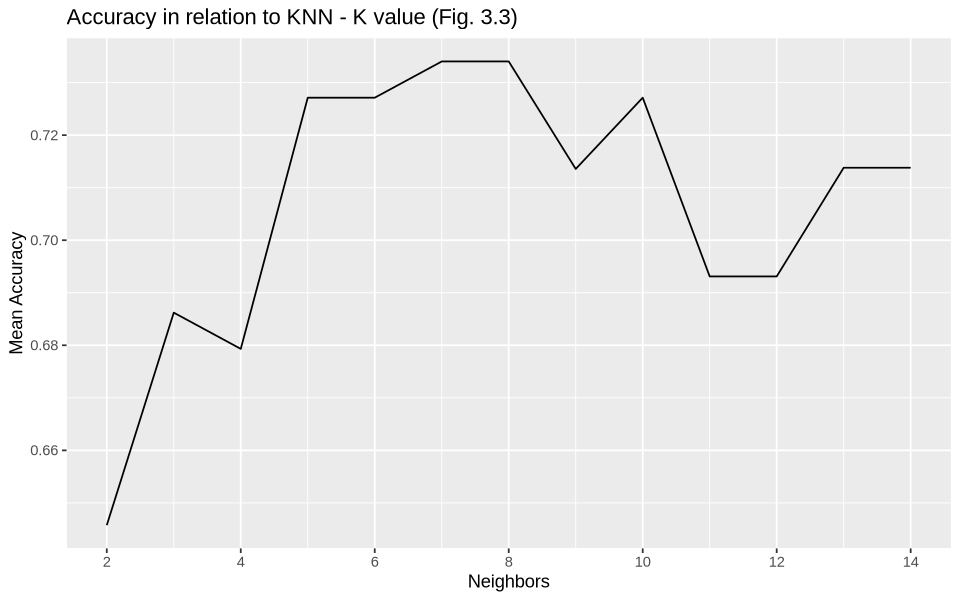

In [33]:
metrics_plot <- knn_results %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_line() +
    labs(title = "Accuracy in relation to KNN - K value (Fig. 3.3)", x = "Neighbors", y = "Mean Accuracy")+
    scale_x_continuous(breaks = seq(0, 20, by = 2))
metrics_plot

As shown in the graph, the optimal number of neighbors for this KNN model is 7. This is because for k-values greater than 7, the accuracy value begins to flatline and decline.

**Step 3:** Run model

In [37]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
                set_mode("classification") %>%
                set_engine("kknn")
knn_recipe <- recipe(subscribe ~ played_hours, data = player_test) %>%
  step_center(all_predictors()) %>%
  step_scale(all_predictors()) 

knn_fit <- workflow() %>%
        add_model(knn_spec) %>%
        add_recipe(knn_recipe) %>%
        fit(player_test)


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2244898
Best kernel: rectangular
Best k: 7

**Results:** 
After tuning my KNN model and optimizing the value of nearest neighbors, 7. We have created an accuracy of 0.775 or 75.5%

Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

References:

James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. *An Introduction to Statistical Learning.* 1st ed. Springer. https://www.statlearning.com/.